## Plant Disease Detection

To feed a population of 9 billion people by 2050, society will need to raise food production by an estimated 70%. Infectious diseases currently diminish potential output by an average of 40%, with many farmers in developing countries experiencing yield losses of up to 100%. The widespread use of smartphones among crop growers around the world has the potential to transform the smartphone into a useful tool for a wide range of food-growing groups. The development of mobile disease diagnostics using machine learning and big data is one such use.

I will create a Convolutional Neural Network which will be able to predict whether a plant is suffering from a disease.  I will be using tensoflow and keras for this classification. 

In [15]:
# import librarbies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize, LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

First,  I will observe some of the images that are in the dataset.  

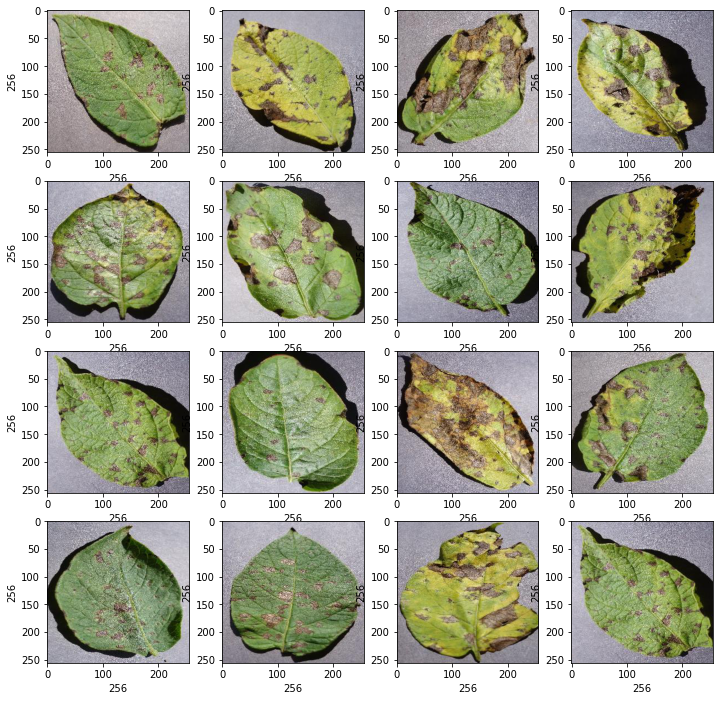

In [16]:
# plot 12 images
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/ML Projects /PlantData.zip (Unzipped Files)/Collab Code/Data/Plant_images_pianalytix/Potato___Early_blight"
for i in range(1,17):
  plt.subplot(4,4,i)
  rand_img = imread(path + "/" + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10) #width of image
  plt.ylabel(rand_img.shape[0], fontsize = 10) # height of image

Now to create a function which will convert the images into a numpy array.  This is required so I can normalise the dataset. 

In [17]:
# convert images to an array
def convert_image_to_array(image_dir):
  try: 
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize(image, (256,256))
      # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) - grayscaling may improve accuracy
      return img_to_array(image)
    else: 
      return np.array([])
  except Exception as e:
    print(f"Error:  {e}")
    return None

Calling the function on the images: 

In [18]:
dir = "/content/drive/MyDrive/ML Projects /PlantData.zip (Unzipped Files)/Collab Code/Data/Plant_images_pianalytix"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ["Corn-Common_rust", "Potato-Early_blight", "Tomato-Bacterial_spot"]
binary_labels = [0,1,2]
temp = -1

# reading and converting images to numpy array
for directory in root_dir: 
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list: 
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

It's import to visualise the number of images under each class to ensure the dataset is balanced. 

In [19]:
# visualising the number of class counts
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
1    300
2    300
dtype: int64

Observing the shape of the images. 

In [20]:
image_list[0].shape

(256, 256, 3)

The images are 256x256 and the 3 indicates the colour channels,  this example being RGB.  Now,  I will check the total number of the images. 

In [21]:
label_list = np.array(label_list)
label_list.shape

(900,)

900 is consistent with the image under class count.   The next step is to split these 900 images into a train and test set. 

In [24]:
# split the data
# 80% for training, 20% for testing. 
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

The dataset is now split.  Normalisation is the next step.  The pixel values of these images runs from 0 - 255, so I will divide each image pixel with 255 to normalise. 

In [25]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
# reshape
x_train = x_train.reshape(-1, 256,256,3)
x_test = x_test.reshape(-1, 256,256,3)

Now,  I encode the y_train and y_test using the `to_categorical()` function from keras. 

In [26]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

It's time to build the CNN architecture for the model.  I will use different types of layers according to their features:  

**Conv_2d:**  is used to create a Convolutional Kernel that is colnvolved with the input layer to produce the output tensor. 
 
**Max_pooling2d:**  is a downsampling technique which takes out the maximum value over the window defined by the poolsize. 

**Flatten:** flattens the input and creates a 1D output. 

**Dense:** the dense layer produce the output as the dot product of input and kernel. 

In [28]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape = (256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64, (3,3), padding="same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dense(3, activation = "softmax")) #3 neurons for 3 classes with the softmax kernel
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 112896)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

7.24m params which are all trainable.  Now, I can compile the model.  I have set the type of loss as a binary crossentropy as well as set the optimiser and metric. 

In [29]:
model.compile(loss = "categorical_crossentropy", optimizer = Adam(0.0001), metrics = ["accuracy"])

A split of the dataset for training and validation is now required

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

I will now fit the modell and compute the accuracy of the model at each epoch to monitor how the CNN is learning.   

In [32]:
epochs = 100
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/100
5/5 [==============================] - 3s 636ms/step - loss: 0.8635 - accuracy: 0.7066 - val_loss: 0.6309 - val_accuracy: 0.6389
Epoch 2/100
5/5 [==============================] - 1s 283ms/step - loss: 0.5035 - accuracy: 0.8733 - val_loss: 0.4351 - val_accuracy: 0.7500
Epoch 3/100
5/5 [==============================] - 1s 283ms/step - loss: 0.3314 - accuracy: 0.8976 - val_loss: 0.2972 - val_accuracy: 0.9167
Epoch 4/100
5/5 [==============================] - 1s 282ms/step - loss: 0.2241 - accuracy: 0.9392 - val_loss: 0.2612 - val_accuracy: 0.8958
Epoch 5/100
5/5 [==============================] - 1s 283ms/step - loss: 0.1624 - accuracy: 0.9722 - val_loss: 0.1990 - val_accuracy: 0.9444
Epoch 6/100
5/5 [==============================] - 1s 284ms/step - loss: 0.1171 - accuracy: 0.9792 - val_loss: 0.1528 - val_accuracy: 0.9514
Epoch 7/100
5/5 [==============================] - 1s 283ms/step - loss: 0.0912 - accuracy: 0.9826 - val_loss: 0.1072 - val_accuracy: 0.9722
Epoch 8/100
5

Saving the model.. 

In [33]:
model.save("/content/drive/MyDrive/ML Projects /PlantData.zip (Unzipped Files)/plant_disease.h5")
#save the weights
model.save_weights("/content/drive/MyDrive/ML Projects /PlantData.zip (Unzipped Files)/plan_model_weights.h5")

Plotting the accuracy of the model. 

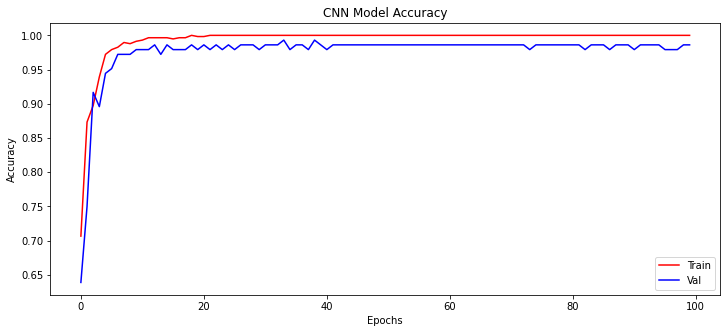

In [34]:
plt.figure(figsize=(12,5))
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="b")
plt.title("CNN Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"])
plt.show()

In [35]:
print("[INFO] Calculating model accuracy..")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy..
6/6 [==============================] - 1s 84ms/step - loss: 0.0101 - accuracy: 0.9944
Test Accuracy: 99.44444298744202


And now.. to predict on the test dataset

In [36]:
y_pred = model.predict(x_test)

Plotting the images to compare..

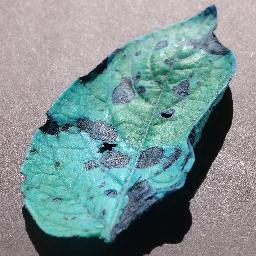

In [38]:
img = array_to_img(x_test[10])
img

Now,  finding the max value from prediction list and comparing it to the originals.. prediction vs original. 

In [42]:
print("Original: ", all_labels[np.argmax(y_test[10])])
print("Predicted: ", all_labels[np.argmax(y_pred[10])])

Original:  Potato-Early_blight
Predicted:  Potato-Early_blight
